In [32]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from dataclasses import dataclass

### Data

In [33]:
@dataclass
class ProcessConfig:
    """configure the data generating process"""
    period: int = 40
    seq_len: int = 10000
    num_seeds: int = 3 
    𝜆: float = 5.0 # poisson rate (number of samples received within a unit time interval)
    p: float = 0.0 # sparse rate (probability of not receiving any samples at a given time)


class DataGeneratingProcess:
    """data generating process"""
    def __init__(self, cfg):
        self.seq_len = cfg.seq_len
        self.num_seeds = cfg.num_seeds
        self.period = cfg.period
        self.𝜆 = cfg.𝜆
        self.p = cfg.p

    def generate_data(self):
        """generate data sequences over the specified number of seeds"""
        xseq, yseq, tseq, taskseq = [], [], [], []
        for _ in range(self.num_seeds):
            dat = self.generate_sequence(np.random.randint(0, 10000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            tseq.append(dat[2])
            taskseq.append(dat[3])

        self.data = {'x': xseq,
                     'y': yseq,
                     't': tseq,
                     'task': taskseq}

    def generate_sequence(self, seed):
        """generate a sequence of data"""
        np.random.seed(seed)

        T = self.period

        n_list = np.random.poisson(self.𝜆, self.seq_len) if self.𝜆 > 0 else np.ones(self.seq_len, dtype=int)
        drop_list = np.random.binomial(1, self.p, self.seq_len).astype(bool)

        data = []
        taskseq = []
        for t, (n, drop) in enumerate(zip(n_list, drop_list)):
            current_task = (t % T) < (T // 2)
            taskseq.append(int(current_task))

            if drop:
                continue

            x1 = np.random.uniform(-2, -1, n)
            x2 = np.random.uniform(1, 2, n)
            mask = np.random.choice([0, 1], p=[0.5, 0.5], size=n)
            x = x1 * mask + x2 * (1 - mask)

            if current_task:
                y = x > 0
            else:
                y = x < 0      
        
            data.append([x, y, t * np.ones(n)])
        
        data = np.concatenate(data, axis=-1)
        Xdat = data[0, :].reshape(-1, 1)
        Ydat = data[1, :].astype(int)
        tind = data[2, :]
        return Xdat, Ydat, tind, taskseq
    
    def generate_at_time(self, t, num_samples):
        """generate a test sample of data (x, y) ~ p_t from the marginal 
        of the process at time t. This is used to evaluate the instantaneous
        loss of the predictor

        might not be needed
        """
        # Generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, num_samples)
        x2 = np.random.uniform(1, 2, num_samples)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=num_samples)
        Xdat = x1 * mask + x2 * (1 - mask)

        # create labels
        T = self.period
        if (t % T) < (T // 2):
            Ydat = Xdat > 0
        else:
            Ydat = Xdat < 0

        Xdat = Xdat.reshape(-1, 1)
        tdat = t * np.ones(num_samples)

        x = torch.from_numpy(Xdat).float()
        y = torch.from_numpy(Ydat).long()
        t = torch.from_numpy(tdat).float()
        return x, y, t
    

class SyntheticDataset(Dataset):
    """Form the torch dataset"""
    def __init__(self, data, present, run_id, test, past=None):
        self.x = torch.from_numpy(data['x'][run_id]).float()
        self.y = torch.from_numpy(data['y'][run_id]).long()
        self.t = torch.from_numpy(data['t'][run_id]).float()

        if test:
            # Use data from time 'present' onwards for testing
            test_idx = torch.where(self.t >= present)
            self.x = self.x[test_idx]
            self.y = self.y[test_idx]
            self.t = self.t[test_idx]
        else:
            if past is None:
                #  # Use data up to time 'idx' onwards for training (full history)
                train_idx = torch.where(self.t < present)
                self.x = self.x[train_idx]
                self.y = self.y[train_idx]
                self.t = self.t[train_idx]
            else:
                # Use the most recent past data up to time 'idx' onwards for training (partial history)
                train_idx = torch.where((self.t >= present-past) & (self.t < present))
                self.x = self.x[train_idx]
                self.y = self.y[train_idx]
                self.t = self.t[train_idx]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        t = self.t[idx]
        return x, y, t

### Models

In [34]:
import torch.nn as nn

class TimeEmbedding(nn.Module):
    """form the time-embedding"""
    def __init__(self, tdim=10):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / torch.arange(2, tdim + 1, 2).unsqueeze(0)

    def forward(self, t):
        sin_emb = torch.sin(self.freqs.to(t.device) * t)
        cos_emb = torch.cos(self.freqs.to(t.device) * t)
        return torch.cat([sin_emb, cos_emb], dim=-1)
    
class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, in_dim=1, out_dim=2, hidden_dim=32, tdim=50, prospective=False):
        super(MLP, self).__init__()
        self.prospective = prospective
        if prospective:
            self.time_embed = TimeEmbedding(tdim=tdim)
            self.fc1 = nn.Linear(in_dim + tdim, hidden_dim)
        else:
            self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, t):
        if self.prospective:
            t = self.time_embed(t.unsqueeze(-1))
            x = torch.cat([x, t], dim=-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Trainer Class

In [35]:
import random
import sys
sys.path.append('../')
from deep_nets.utils.bgd import BGD

def set_seed(acorn):
    """set random seed"""
    random.seed(acorn)
    np.random.seed(acorn)
    torch.manual_seed(acorn)
    torch.cuda.manual_seed(acorn)
    torch.cuda.manual_seed_all(acorn)

def get_dataloaders(dp, t, seed, past=None):
    """obtain the dataloaders"""
    # TODO: Recheck data loaders before running OGD
    if past:
        if t < 16:
            train_dataset = SyntheticDataset(dp.data, t, seed, test=False, past=None)
        else:
            train_dataset = SyntheticDataset(dp.data, t, seed, test=False, past=past)
    else:
        train_dataset = SyntheticDataset(dp.data, t, seed, test=False, past=None)
    test_dataset = SyntheticDataset(dp.data, t, seed, test=True)
    ttest_dataset = TensorDataset(*dp.generate_at_time(t, 500))

    # if t < 64:
    #     bs = 2
    # else:
    #     if past:
    #         if t < 8: bs = 2
    #         else: bs = 8
    #     else:
    #         bs = 32

    if len(train_dataset) > 32:
        bs = 32
    else:
        bs = 2
            
    trainloader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=True
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )
    return trainloader, testloader, ttestloader

def get_optimizer(model, bgd=False):
    """Obtain the appropriate optimizer"""
    if bgd:
        params = [{'params': [p]} for p in model.parameters()]
        optimizer = BGD(params, std_init=0.01)
    else:
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=0.1,
            momentum=0.9, 
            nesterov=True,
            weight_decay=0.00001
        )
    return optimizer

class Trainer:
    """trainer class for the models"""
    def __init__(self, model, train_loader, test_loader, ttest_loader, optimizer, device, verbose=False):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.ttest_loader = ttest_loader

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optimizer

        self.device = device
        self.verbose = verbose

        self.bgd = True if optimizer.__class__.__name__ == 'BGD' else False

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        for batch in self.train_loader:
            batch = [b.to(self.device) for b in batch]
            x, y, t = batch

            if self.bgd:
                bs = x.size(0)
                for mc_iter in range(10):
                    self.optimizer.randomize_weights()
                    outputs = self.model(x, t)
                    loss = self.criterion(outputs.squeeze(), y)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.aggregate_grads(bs)
            else:
                outputs = self.model(x, t)
                loss = self.criterion(outputs.squeeze(), y)
                self.optimizer.zero_grad()  
                loss.backward()  

            self.optimizer.step() 
            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    def evaluate(self, model=None):
        if model:
            self.model = model
        self.model.eval()
        perrs = []
        with torch.no_grad():
            for batch in self.test_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                perrs.append(err.cpu().numpy())
        perrs = np.concatenate(perrs)
        ploss = perrs.mean()

        errs = []
        with torch.no_grad():
            for batch in self.ttest_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                errs.append(err.cpu().numpy())
        iloss = np.concatenate(errs).mean()
        return iloss, ploss, perrs

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch()
            if self.verbose:
                print(f'Epoch [{epoch + 1}/{num_epochs}], '
                    f'Train Loss: {train_loss:.4f}, ')
        print(f"training loss at last epoch: {train_loss:.3f}")

### Experiment run

In [ ]:
# configure and obtain the data generating process
period = 40
seq_len = 10000
𝜆 = 0
p = 0.5

cfg = ProcessConfig(
    period=period,
    seq_len=seq_len,
    num_seeds=3,
    𝜆=𝜆,
    p=p
)
dp = DataGeneratingProcess(cfg)
dp.generate_data()

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# learners being considered
methods = ["FTL", "Prospective"]
# methods = ["FTL", "Prospective", "OGD", "BGD"]

t_list = np.arange(20, 1000, 1) # list of time steps 

instant_risk = {} # store instant risk for each algorithm
prospective_risk = {} # store prospective risk for each algorithm

for method in methods:
    instant_losses = []
    prospective_losses = []
    for seed in range(cfg.num_seeds):
        print(f"seed = {seed}")
        acorn = seed * 1000 + 1996
        set_seed(acorn)

        online = ("OGD" in method) or ("BGD" in method)

        if online:
            model = MLP(prospective=False)
            model.to(device)
            optimizer = get_optimizer(model, bgd=True if "BGD" in method else False)

        iloss_list = []
        ploss_list = []
        
        for t in t_list:
            print(f"time t = {t}")

            if online:
                is_first_step = True if t == t_list[0] else False
                trainloader, testloader, ttestloader = get_dataloaders(dp, t, seed, past=None if is_first_step else 16)
                trainer = Trainer(model, trainloader, testloader, ttestloader, optimizer, device)
                if t > 2:
                    trainer.train(num_epochs=100 if is_first_step else 1)
            else:
                trainloader, testloader, ttestloader = get_dataloaders(dp, t, seed)
                prospective = True if "Prospective" in method else False
                model = MLP(prospective=prospective)
                model.to(device)
                optimizer = get_optimizer(model)
                trainer = Trainer(model, trainloader, testloader, ttestloader, optimizer, device)
                if t > 2:
                    trainer.train(num_epochs=100)
                
            iloss, ploss, _ = trainer.evaluate()
            iloss_list.append(iloss)
            ploss_list.append(ploss)

        instant_losses.append(iloss_list)
        prospective_losses.append(ploss_list)

    instant_risk[method] = np.stack(instant_losses).mean(axis=0)
    prospective_risk[method] = np.stack(prospective_losses).mean(axis=0)


seed = 0
time t = 20
training loss at last epoch: 0.000
time t = 21
training loss at last epoch: 0.198
time t = 22
training loss at last epoch: 0.517
time t = 23
training loss at last epoch: 0.503
time t = 24
training loss at last epoch: 0.466
time t = 25
training loss at last epoch: 0.381
time t = 26
training loss at last epoch: 0.448
time t = 27
training loss at last epoch: 0.496
time t = 28
training loss at last epoch: 0.666
time t = 29
training loss at last epoch: 0.638
time t = 30
training loss at last epoch: 0.720
time t = 31
training loss at last epoch: 0.764
time t = 32
training loss at last epoch: 0.714
time t = 33
training loss at last epoch: 0.731
time t = 34
training loss at last epoch: 0.734
time t = 35
training loss at last epoch: 0.735
time t = 36
training loss at last epoch: 0.716
time t = 37
training loss at last epoch: 0.715
time t = 38
training loss at last epoch: 0.716
time t = 39
training loss at last epoch: 0.719
time t = 40
training loss at last epoch: 0.701
time

### Save results

In [30]:
# save the results
import pickle
results = {
    "prisk": prospective_risk, 
    "irisk": instant_risk
}
with open(f'results_lambda_{𝜆}_p_{p}.pkl', 'wb') as file:
    pickle.dump(results, file)

### Plot

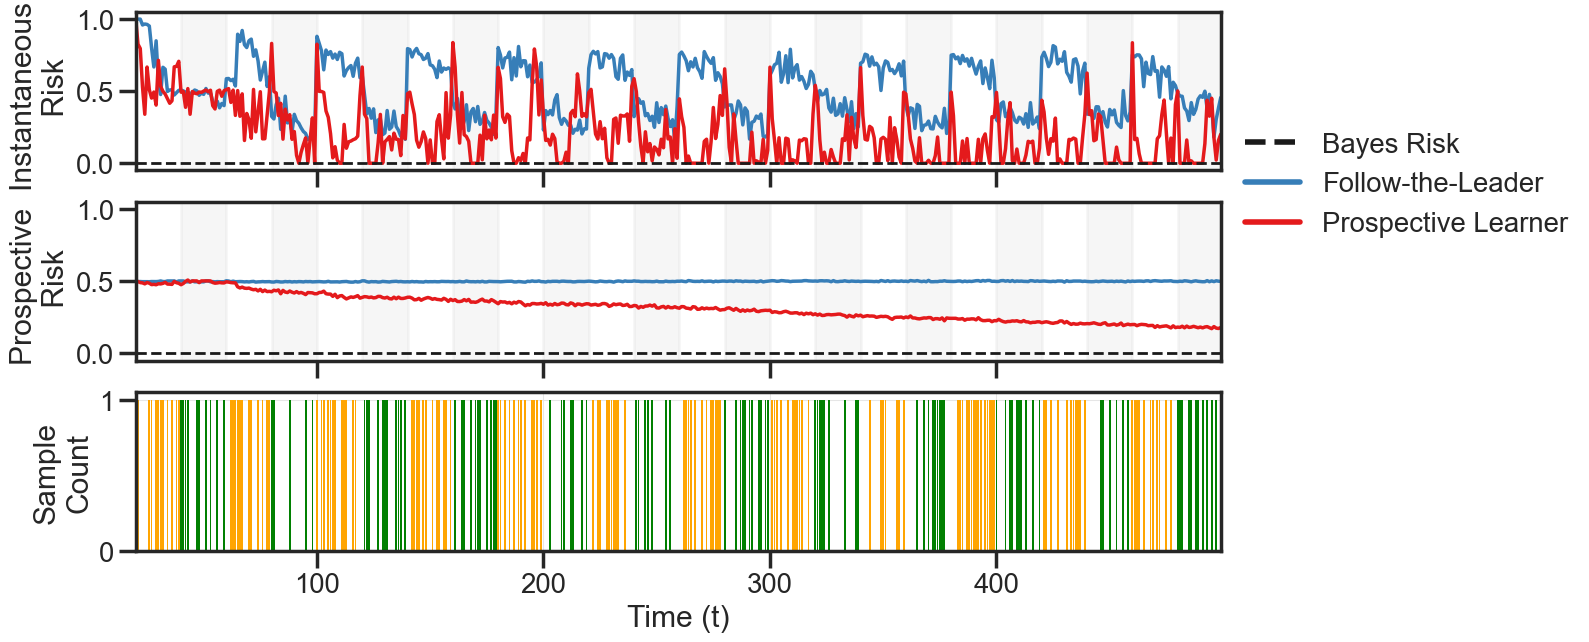

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("default")
sns.set(context='poster',
            style='ticks',
            font_scale=0.9,
            rc={'axes.grid':True,
                'grid.color':'.9',
                'grid.linewidth':0.75})
from matplotlib.lines import Line2D

fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3']

for i, method in enumerate(methods):
    ax = axes[0]
    ax.plot(t_list, instant_risk[method], color=colors[i], lw=2.5, label=method)
    ax.set_ylabel("Instantaneous \n Risk")
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])

    ax = axes[1]
    ax.plot(t_list, prospective_risk[method], color=colors[i], lw=2.5)
    ax.set_ylabel("Prospective \n Risk")
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])

switch_times = np.arange(0, t_list[-1]+2, period//2)
for i in range(0, len(switch_times)-1, 2):
    for j in range(0, 2):
        ax = axes[j]
        ax.fill_betweenx([-0.1, 1.1], switch_times[i], switch_times[i+1], color='lightgray', alpha=0.2)
        
for j in range(0, 2):
    ax = axes[j]
    ax.plot(t_list, np.zeros_like(t_list), lw=2, ls='dashed', color='k', label="Bayes Risk")
axes[0].grid(visible=False)
axes[1].grid(visible=False)

legend_elements = [
    Line2D([0], [0], color='k', lw=4, ls='dashed', label='Bayes Risk'),
    Line2D([0], [0], color='#377eb8', lw=4, label='Follow-the-Leader'),
    # Line2D([0], [0], color='#4daf4a', lw=4, label='Online GD'),
    # Line2D([0], [0], color='#984ea3', lw=4, label='Bayesian GD'),
    Line2D([0], [0], color='#e41a1c', lw=4, label='Prospective Learner'),
]

ax = axes[0]
ax.legend(handles=legend_elements, frameon=False, loc='upper left', bbox_to_anchor=(1, 0.4))

# plot the sample counts at each time for a single seed
ax = axes[2]
times = dp.data['t'][0]
tasks = np.array(dp.data['task'][0])[t_list]
sample_count_per_time = np.array([sum(times == i) for i in t_list])
colors = ['green' if tsk == 1 else 'orange' for tsk in tasks]
ax.bar(t_list, sample_count_per_time, color=colors, linewidth=0.01)
ax.set_ylabel("Sample\nCount")
ax.set_xlabel("Time (t)")

plt.savefig(f"sparsity_lambda_{𝜆}_p_{p}.pdf", bbox_inches='tight')
plt.show()

In [10]:
period = 40
seq_len = 10000
𝜆 = 0
p = 0.5

cfg = ProcessConfig(
    period=period,
    seq_len=seq_len,
    num_seeds=3,
    𝜆=𝜆,
    p=p
)
dp = DataGeneratingProcess(cfg)
dp.generate_data()

t_list = np.arange(20, 500, 1)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylabel'

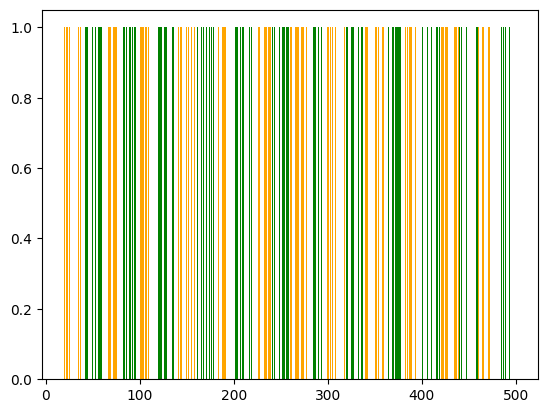

In [12]:
import matplotlib.pyplot as plt
times = dp.data['t'][0]
tasks = np.array(dp.data['task'][0])[t_list]
sample_count_per_time = np.array([sum(times == i) for i in t_list])
colors = ['green' if tsk == 1 else 'orange' for tsk in tasks]
plt.bar(t_list, sample_count_per_time, color=colors, linewidth=0.01)
plt.set_ylabel("Sample\nCount")
plt.set_xlabel("Time (t)")